Name: Holly Kular\
Date: 10-18-2024\
Email: hkular@ucsd.edu\
Description: look at PCA of stim representations in RNN over time

In [14]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colormaps
from scipy.stats import ttest_ind
from scipy.spatial.distance import euclidean
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [2]:
# which model do we want to explore
afc = 6
coh = 'lo'
mod = 0

In [3]:
# load model and trials

if sys.platform.startswith('linux'):
        data_dir = f"/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/rdk_70_30_{afc}afc/feedforward_only/{coh}_coh"
else:
        data_dir = f"/Volumes/serenceslab/holly/RNN_Geo/data/rdk_70_30_{afc}afc/feedforward_only/{coh}_coh"
        
mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat') and not f.startswith('._')]# Get all the trained models (should be 40 .mat files)
model_path = os.path.join(data_dir, mat_files[mod]) 
model = loadmat(model_path)   
data_file = f"{data_dir}/Trials1000_model{model_path[-7:-4]}_neutral.npz"
data = np.load(data_file) #fr1 fr3 outs labs


### calculate PCA and plot for a single layer - separate plots per label

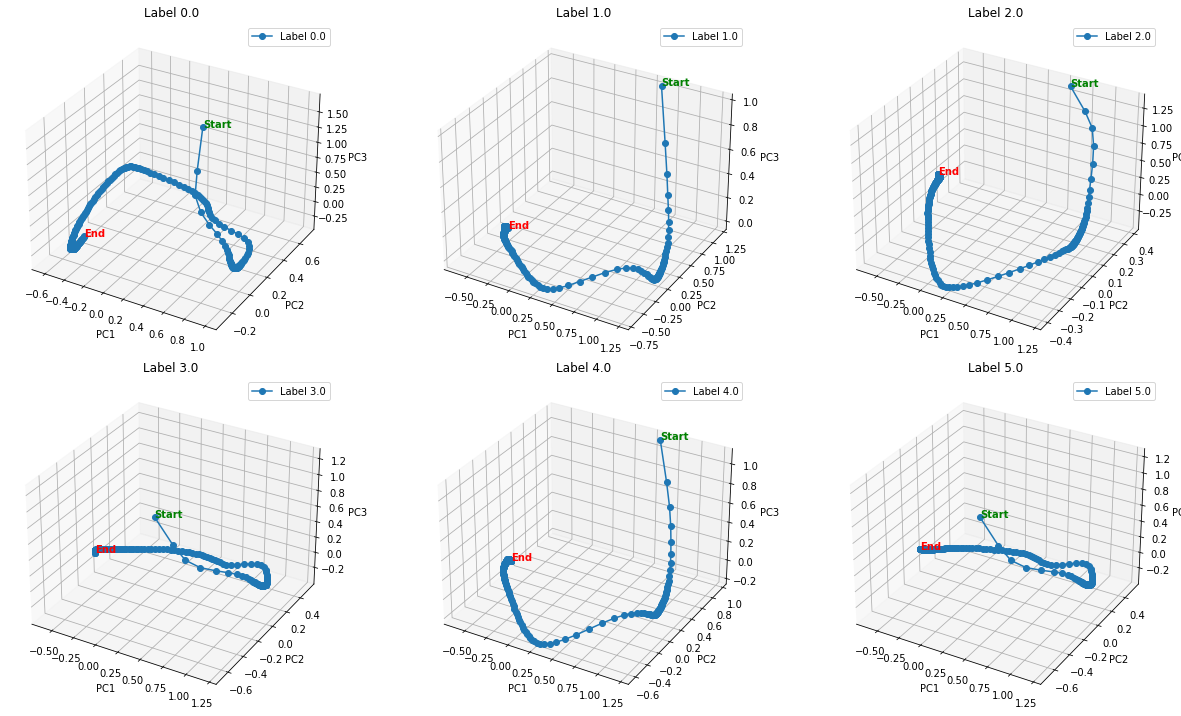

In [5]:
# data['fr1'] is your firing rate data: trial x time x units
fr = data['fr1'] # shape (1000, 250, 200) trials x time x units
labels = data['labs'].flatten()  # labels are 1D, shape (1000,)trials


unique_labels = np.unique(labels)

# Prepare arrays to store results
start_points = []
end_points = []
labels_all = []

fig = plt.figure(figsize=(18, 10))

for i, label in enumerate(unique_labels):
    # Create a subplot for each label
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')  # Adjust rows/cols as needed

    # Filter trials for this label
    label_idx = labels == label
    fr_label = fr[label_idx]  # trials for this label, shape: trials x time x units

    # Average across trials to simplify (optional)
    #fr_mean = fr_label.mean(axis=0)  # shape: time x units
    # instead of average across trials collapse trials by time
    fr_col = fr_label.reshape((fr_label.shape[0]*fr_label.shape[1], fr_label.shape[2]))

    # Perform PCA
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(fr_col)  # shape: time x components
    
    pcs_r = pcs.reshape((fr_label.shape[0], fr_label.shape[1], 3))
    pcs_s = pcs_r.mean(axis=0)

    # Plot first two PCs
    ax.plot(pcs_s[:, 0], pcs_s[:, 1], pcs_s[:,2], marker='o', label=f'Label {label}')
    ax.set_title(f'Label {label}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.legend()
    ax.grid(True)
    # Label start and end points
    ax.text(pcs_s[0, 0], pcs_s[0, 1], pcs_s[0, 2], 'Start', color='green', fontsize=10, fontweight='bold')
    ax.text(pcs_s[-1, 0], pcs_s[-1, 1], pcs_s[-1, 2], 'End', color='red', fontsize=10, fontweight='bold')


# Adjust layout
plt.tight_layout()
plt.show()

### labels in separate plots, plot clouds of start and end points

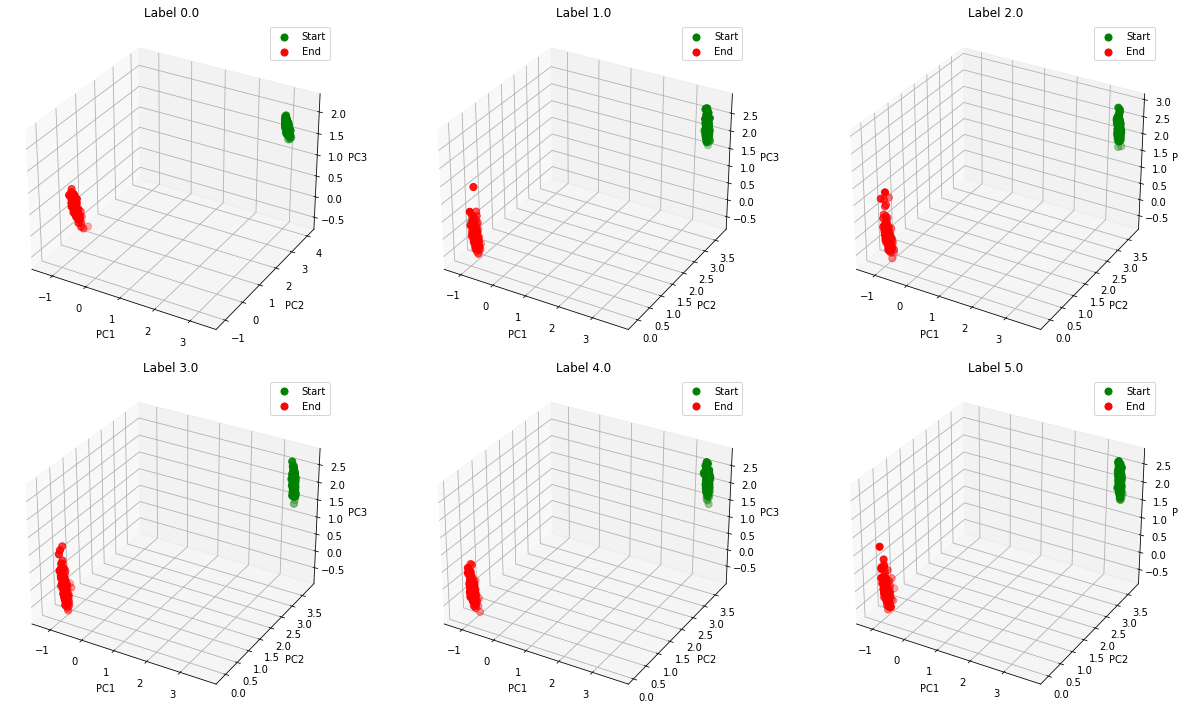

In [7]:
fig = plt.figure(figsize=(18, 10))
fr = data['fr1'] # shape (1000, 250, 200) trials x time x units
labels = data['labs'].flatten()  # labels are 1D, shape (1000,)trials


unique_labels = np.unique(labels)

for i, label in enumerate(unique_labels):
    # Create a subplot for each label
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')  # Adjust rows/cols as needed

    # Filter trials for this label
    label_idx = labels == label
    fr_label = fr[label_idx]  # trials for this label, shape: trials x time x units

    # Reshape trials into time-units
    fr_col = fr_label.reshape((fr_label.shape[0] * fr_label.shape[1], fr_label.shape[2]))

    # Perform PCA
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(fr_col)  # shape: (total_points, 3)

    # Reshape to identify time points per trial
    pcs_r = pcs.reshape((fr_label.shape[0], fr_label.shape[1], 3))  # (trials, time, components)

    # Flatten data for plotting all points
    pcs_flat = pcs_r.reshape((-1, 3))  # shape: (trials * time, 3)

    # Scatter all points
    #ax.scatter(pcs_flat[:, 0], pcs_flat[:, 1], pcs_flat[:, 2], alpha=0.5, label=f'Label {label}')

    # Mark the start and end points
    ax.scatter(pcs_r[:, 0, 0], pcs_r[:, 0, 1], pcs_r[:, 0, 2], color='green', s=50, label='Start')  # First time point
    ax.scatter(pcs_r[:, -1, 0], pcs_r[:, -1, 1], pcs_r[:, -1, 2], color='red', s=50, label='End')  # Last time point

    # Set labels and title
    ax.set_title(f'Label {label}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


### labels in one plot clouds of start and end points

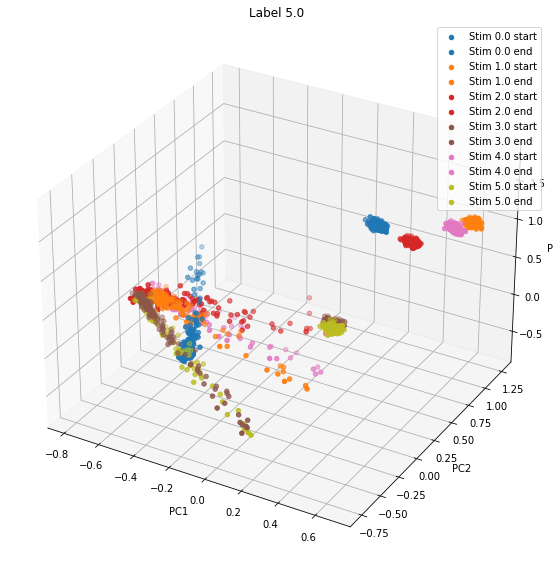

In [10]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

fr = data['fr3']

# Define a colormap for the labels
colormap = colormaps.get_cmap('tab10')
colors = [colormap(i / len(unique_labels)) for i in range(len(unique_labels))]


for i, label in enumerate(unique_labels):

    # Filter trials for this label
    label_idx = labels == label
    fr_label = fr[label_idx]  # trials for this label, shape: trials x time x units

    # Reshape trials into time-units
    fr_col = fr_label.reshape((fr_label.shape[0] * fr_label.shape[1], fr_label.shape[2]))

    # Perform PCA
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(fr_col)  # shape: (total_points, 3)

    # Reshape to identify time points per trial
    pcs_r = pcs.reshape((fr_label.shape[0], fr_label.shape[1], 3))  # (trials, time, components)

    # Flatten data for plotting all points
    pcs_flat = pcs_r.reshape((-1, 3))  # shape: (trials * time, 3)

    # Scatter all points
    #ax.scatter(pcs_flat[:, 0], pcs_flat[:, 1], pcs_flat[:, 2], alpha=0.5, label=f'Label {label}')

    # Mark the start and end points
    ax.scatter(pcs_r[:, 0, 0], pcs_r[:, 0, 1], pcs_r[:, 0, 2],  label=f'Stim {label} start', color=colors[i])  # First time point
    ax.scatter(pcs_r[:, -1, 0], pcs_r[:, -1, 1], pcs_r[:, -1, 2],  label=f'Stim {label} end', color=colors[i])  # Last time point

    # Set labels and title
    ax.set_title(f'Label {label}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

### Compare start and end points - stats

In [35]:
# Prepare arrays to store results
start_points = []
end_points = []
labels_all = []
fr = data['fr2'] # shape (1000, 250, 200) trials x time x units
labels = data['labs'].flatten()  # labels are 1D, shape (1000,)trials



for label in unique_labels:
    # Filter trials and calculate mean trajectory
    label_idx = labels == label
    fr_label = fr[label_idx]
    fr_col = fr_label.reshape((fr_label.shape[0] * fr_label.shape[1], fr_label.shape[2]))
    pcs = PCA(n_components=3).fit_transform(fr_col)
    pcs_r = pcs.reshape((fr_label.shape[0], fr_label.shape[1], 3))
    #pcs_s = pcs_r.mean(axis=0)
    
    # Extract start and end points
    start_points.append(pcs_r[:, 0, :])  # Start point
    end_points.append(pcs_r[:, -1, :])  # End point

start_points = np.array(start_points)  # shape: (n_labels,)
end_points = np.array(end_points)      # shape: (n_labels,)


# Perform pairwise comparisons between labels
results = []
for (label1, label2) in combinations(range(len(unique_labels)), 2):
    # Compute Euclidean distances between start points of label1 and label2
    t_stat_start, p_val_start = ttest_ind(
        start_points[label1],
        start_points[label2],
        equal_var=False, axis = 0
    )
    # Compute Euclidean distances between end points of label1 and label2
    t_stat_end, p_val_end = ttest_ind(
        end_points[label1],
        end_points[label2],
        equal_var=False, axis = 0
    )
    
    results.append({
        "Labels": (unique_labels[label1], unique_labels[label2]),
        "Start p-value": p_val_start,
        "End p-value": p_val_end,
    })

In [36]:
for result in results:
    start_pvals = result["Start p-value"]  # Should be a list or tuple of 3 p-values
    end_pvals = result["End p-value"]      # Same as above
    labels = result["Labels"]

    # Check if any p-value in the start or end exceeds 0.01
    if any(p < 0.01 for p in start_pvals) or any(p < 0.01 for p in end_pvals):
        print(f"Labels: {labels}")
        print(f"Start p-values: {start_pvals}")
        print(f"End p-values: {end_pvals}")

Labels: (0.0, 1.0)
Start p-values: [0. 0. 0.]
End p-values: [1.12174921e-104 1.38315441e-218 3.05672377e-099]
Labels: (0.0, 2.0)
Start p-values: [0. 0. 0.]
End p-values: [1.17978233e-107 9.37598807e-181 9.40332814e-093]
Labels: (0.0, 3.0)
Start p-values: [0. 0. 0.]
End p-values: [1.95588125e-108 3.96575826e-194 3.56737791e-095]
Labels: (0.0, 4.0)
Start p-values: [0. 0. 0.]
End p-values: [5.23902625e-107 7.90672304e-207 6.78581073e-098]
Labels: (0.0, 5.0)
Start p-values: [0. 0. 0.]
End p-values: [5.10540792e-108 3.08535712e-205 5.48331797e-094]
Labels: (1.0, 2.0)
Start p-values: [3.12930737e-074 1.35113070e-006 1.14521729e-130]
End p-values: [0.14979978 0.00086543 0.01597448]
Labels: (1.0, 3.0)
Start p-values: [7.28026558e-95 4.88562576e-06 8.29074512e-94]
End p-values: [0.38295381 0.00039939 0.30194847]
Labels: (1.0, 4.0)
Start p-values: [1.59292973e-111 1.42436504e-003 6.53948866e-093]
End p-values: [3.85147452e-01 3.20481543e-04 5.43209861e-01]
Labels: (1.0, 5.0)
Start p-values: [7.4

### calculate PCA and save plot for each layer - all labels in one plot

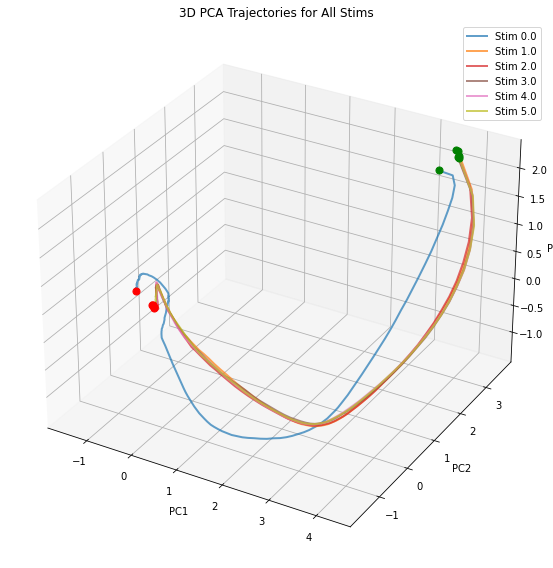

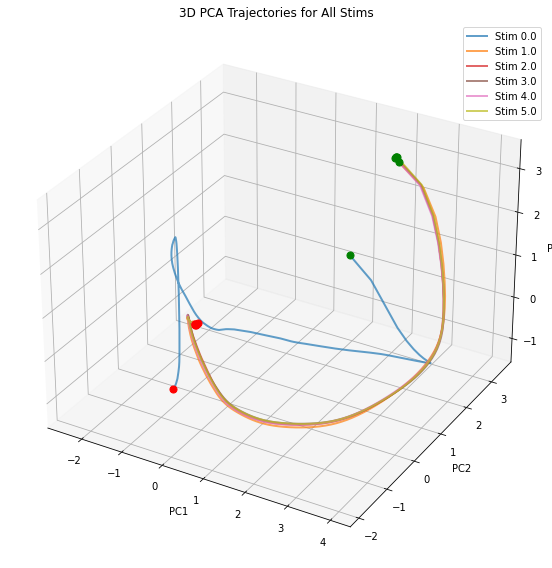

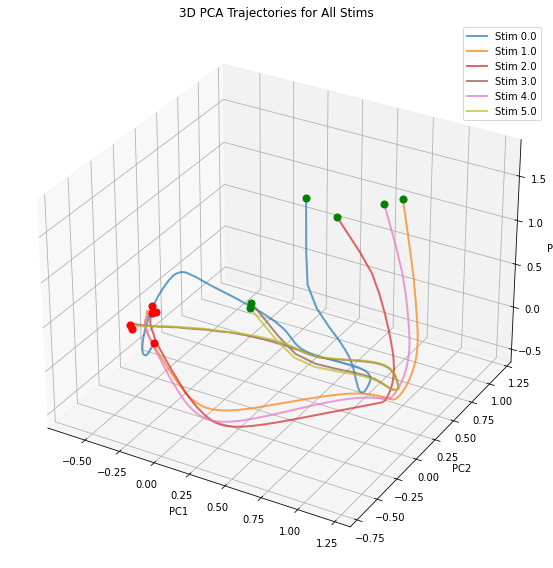

In [4]:
# Initialize the figure

for layer in range(3):

    layer+=1
    fr = data[f'fr{layer}']
    labels = data['labs'].flatten() 

    unique_labels = np.unique(labels)
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Define a colormap for the labels
    colormap = colormaps.get_cmap('tab10')
    colors = [colormap(i / len(unique_labels)) for i in range(len(unique_labels))]

    for i, label in enumerate(unique_labels):
        # Filter trials for this label
        label_idx = labels == label
        fr_label = fr[label_idx]  # trials for this label, shape: trials x time x units

        # Average across trials to simplify
        #fr_mean = fr_label.mean(axis=0)  # shape: time x units
        # collapse across trials and time
        fr_col = fr_label.reshape((fr_label.shape[0]*fr_label.shape[1], fr_label.shape[2]))

        # Perform PCA
        pca = PCA(n_components=3)
        pcs_s = pca.fit_transform(fr_col)  # shape: time x components
        pcs_r = pcs_s.reshape((fr_label.shape[0], fr_label.shape[1], 3))
        pcs = pcs_r.mean(axis=0)

        # Plot trajectory
        ax.plot(pcs[:, 0], pcs[:, 1], pcs[:, 2], label=f'Stim {label}', color=colors[i], alpha=0.7, linewidth = 2)

        # Mark start (green) and end (red) points
        ax.scatter(pcs[0, 0], pcs[0, 1], pcs[0, 2], color='green', s=50, label= '_nolegend_')
        ax.scatter(pcs[-1, 0], pcs[-1, 1], pcs[-1, 2], color='red', s=50, label='_nolegend_')

    # Add axis labels
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    # Add title and legend
    ax.set_title('3D PCA Trajectories for All Stims')
    ax.legend()
    plt.tight_layout()
    fname = f"/Volumes/serenceslab/holly/RNN_Geo/04_PCA/{afc}afc/PCA_stims_fr{layer}_{coh}_mod{mod}"
    #plt.savefig(fname)
    plt.show()

# calculate the multidimensional euclidean distance

#### plot euclid distances for single model all layers

<ipython-input-72-76d8e376b6fc>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  layer_colormap = plt.cm.get_cmap('Set1')


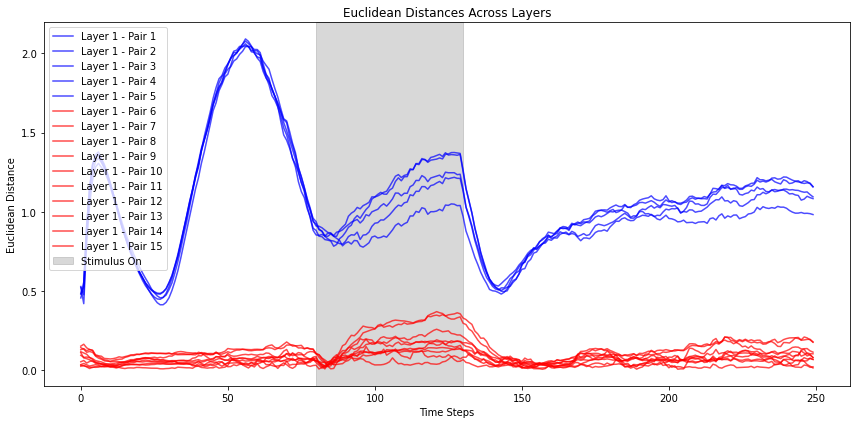

In [72]:
# calculate distances for each layer and create plot


labels = data['labs'].flatten() 
unique_labels = np.unique(labels)

# Initialize a figure
plt.figure(figsize=(12, 6))

# Color map for different layers
layer_colormap = plt.cm.get_cmap('Set1')
colormap = colormaps.get_cmap('tab10')

# Loop over layers
for layer_idx, layer in enumerate([1]):  
    
    fr = data[f'fr{layer}']

    # Define a colormap for the labels
    colors = [colormap(i / len(unique_labels)) for i in range(len(unique_labels))]

    pcs_all = np.zeros((fr.shape[1], 3, len(unique_labels)))

    for i, label in enumerate(unique_labels):
        # Filter trials for this label
        label_idx = labels == label
        fr_label = fr[label_idx]  # trials for this label, shape: trials x time x units

        # collapse across trials and time
        fr_col = fr_label.reshape((fr_label.shape[0]*fr_label.shape[1], fr_label.shape[2]))

        # Perform PCA
        pca = PCA(n_components=3)
        pcs_s = pca.fit_transform(fr_col)  # shape: time x components
        pcs_r = pcs_s.reshape((fr_label.shape[0], fr_label.shape[1], 3)) # uncollapse trials x time
        pcs_all[:,:, i] = pcs_r.mean(axis=0) #store for each label


    # distances
    num_pairs = len(unique_labels) * (len(unique_labels) - 1) // 2  # Number of unique pairs
    distances = np.zeros((fr.shape[1], num_pairs))
    pair_idx = 0
    for i in range(len(unique_labels)):
        for j in range(i+1, len(unique_labels)):
            # pairwise distance for each time point - L2 norm which is euclidean norm
            distances[:, pair_idx] = np.linalg.norm(
                pcs_all[:, :, i] - pcs_all[:, :, j], axis=1
            )
            pair_idx += 1      

# Plot distances for this layer with a unique color
    layer_color = layer_colormap(layer_idx / 3)
    for pair in range(num_pairs):
        if pair > 4:
            color_pair = "red"
        else: color_pair = "blue"
        plt.plot(np.arange(pcs_all.shape[0]), distances[:, pair], 
                 color=color_pair, 
                 label=f"Layer {layer} - Pair {pair+1}", 
                 alpha=0.7)  # Added some transparency

# Add stimulus period
stim_on = 80
stim_off = 80+50
plt.axvspan(stim_on, stim_off, color='gray', alpha=0.3, label="Stimulus On")

plt.xlabel("Time Steps")
plt.ylabel("Euclidean Distance")
plt.title("Euclidean Distances Across Layers")
plt.legend()
plt.tight_layout()
#fname = f"/Volumes/serenceslab/holly/RNN_Geo/04_PCA/{afc}afc/PCA_dists_allfrs_{coh}_mod{mod}"
#plt.savefig(fname)
plt.show()

#### plot euclid distances for all models all layers

<ipython-input-51-7a6fee4c25ea>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds') if base_color == 'red' else \
<ipython-input-51-7a6fee4c25ea>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.cm.get_cmap('Greens') if base_color == 'green' else \
<ipython-input-51-7a6fee4c25ea>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.cm.get_cmap('Blues')


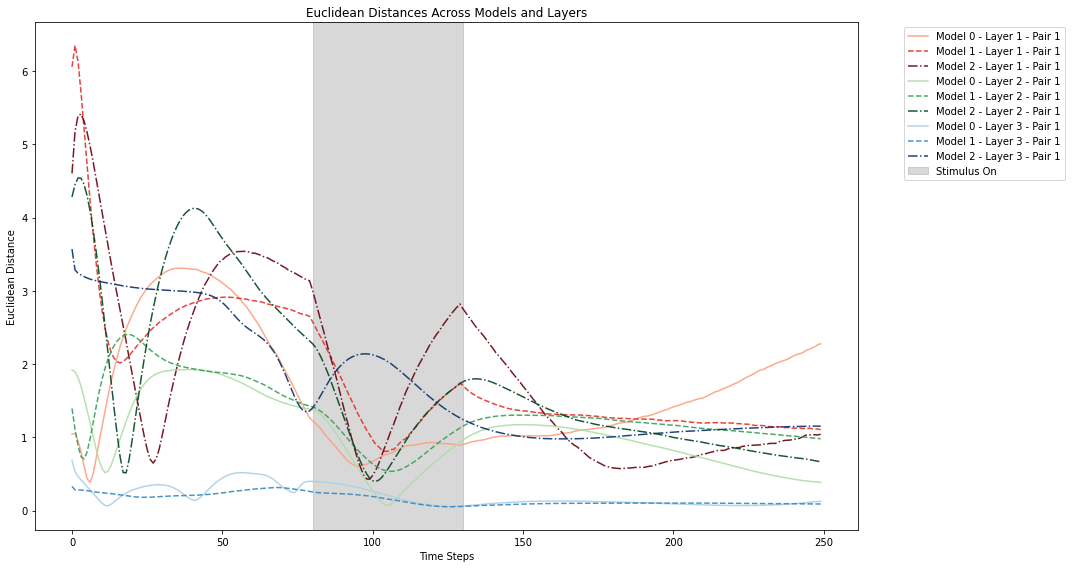

In [51]:
# List of model numbers to loop over
models_to_process = [0, 1, 2]

# Initialize a figure
plt.figure(figsize=(15, 8))

# Define consistent layer colors
layer_colors = {
    1: 'red',     # Layer 1 will be in reds
    2: 'green',  # Layer 2 will be in oranges
    3: 'blue'     # Layer 3 will be in blues
}

# Define line styles for models
line_styles = ['-', '--', '-.']

# Function to generate color variations for a base color
def generate_color_variations(base_color, num_variations):
    # Create a colormap with variations of the base color
    cmap = plt.cm.get_cmap('Reds') if base_color == 'red' else \
           plt.cm.get_cmap('Greens') if base_color == 'green' else \
           plt.cm.get_cmap('Blues')
    return [cmap(i/num_variations) for i in range(1, num_variations+1)]

# Loop over layers first to maintain color consistency
for layer_idx, layer in enumerate([1, 2, 3]):
    # Generate color variations for this layer
    model_layer_colors = generate_color_variations(layer_colors[layer], len(models_to_process))
    
    # Loop over models
    for model_idx, mod in enumerate(models_to_process):
        # Construct the model path
        model_path = os.path.join(data_dir, mat_files[mod]) 
        model = loadmat(model_path)   
        
        # Construct the data file path
        data_file = f"{data_dir}/Trials1000_model{model_path[-7:-4]}_neutral.npz"
        data = np.load(data_file)
        
        # Load data for this layer
        fr = data[f'fr{layer}']
        labels = data['labs'].flatten() 
        unique_labels = np.unique(labels)
        
        # PCA and distance calculations (same as previous code)
        pcs_all = np.zeros((fr.shape[1], 3, len(unique_labels)))
        for i, label in enumerate(unique_labels):
            # Filter trials for this label
            label_idx = labels == label
            fr_label = fr[label_idx]
            fr_col = fr_label.reshape((fr_label.shape[0]*fr_label.shape[1], fr_label.shape[2]))
            
            # Perform PCA
            pca = PCA(n_components=3)
            pcs_s = pca.fit_transform(fr_col)
            pcs_r = pcs_s.reshape((fr_label.shape[0], fr_label.shape[1], 3))
            pcs_all[:,:, i] = pcs_r.mean(axis=0)
        
        # distances
        num_pairs = len(unique_labels) * (len(unique_labels) - 1) // 2
        distances = np.zeros((fr.shape[1], num_pairs))
        pair_idx = 0
        for i in range(len(unique_labels)):
            for j in range(i+1, len(unique_labels)):
                distances[:, pair_idx] = np.linalg.norm(
                    pcs_all[:, :, i] - pcs_all[:, :, j], axis=1
                )
                pair_idx += 1      
        
        # Plot distances for this layer and model
        model_layer_color = model_layer_colors[model_idx]
        model_line_style = line_styles[model_idx]
        
        for pair in range(num_pairs):
            plt.plot(np.arange(pcs_all.shape[0]), distances[:, pair], 
                     color=model_layer_color, 
                     linestyle=model_line_style,
                     label=f"Model {mod} - Layer {layer} - Pair {pair+1}", 
                     alpha=0.9)

# Add stimulus period
stim_on = 80
stim_off = 80+50
plt.axvspan(stim_on, stim_off, color='gray', alpha=0.3, label="Stimulus On")

plt.xlabel("Time Steps")
plt.ylabel("Euclidean Distance")
plt.title("Euclidean Distances Across Models and Layers")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
fname = f"/Volumes/serenceslab/holly/RNN_Geo/04_PCA/{afc}afc/PCA_dists_allfrs_{coh}_allmods"
plt.savefig(fname)
plt.show()

#### plot euclid distances avg across models all layers

<ipython-input-58-f6f36f038812>:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  model_layer_color = plt.cm.get_cmap('Reds')(model_idx/len(models_to_process)) if layer == 1 else \
<ipython-input-58-f6f36f038812>:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  model_layer_color = plt.cm.get_cmap('Reds')(model_idx/len(models_to_process)) if layer == 1 else \
<ipython-input-58-f6f36f038812>:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  model_layer_color = plt.cm.get_cmap('

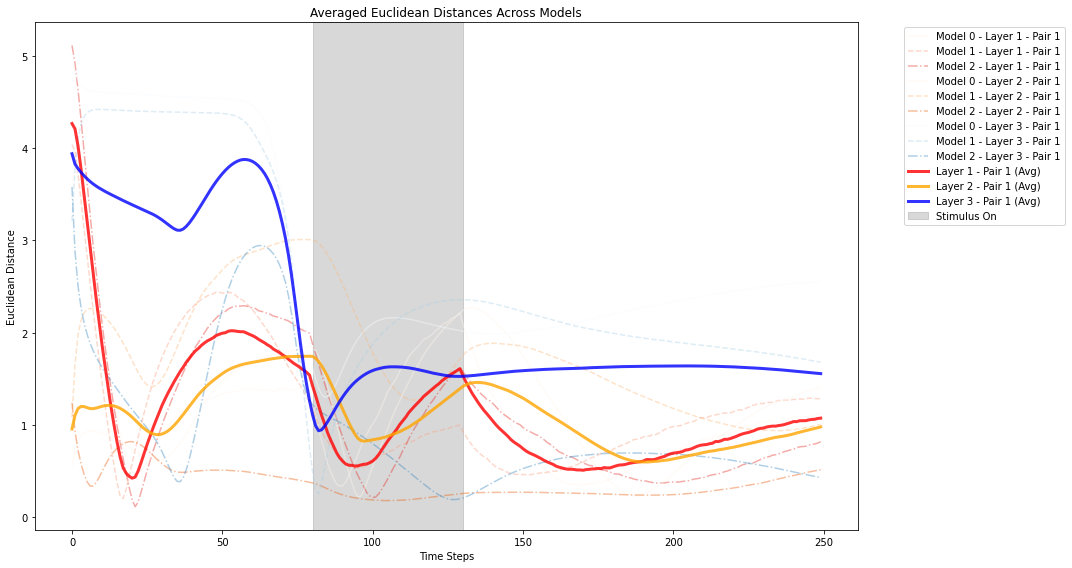

In [58]:
# List of model numbers to loop over
models_to_process = [0, 1, 2]

# Initialize a figure
plt.figure(figsize=(15, 8))

# Define consistent layer colors
layer_colors = {
    1: 'red',     # Layer 1 will be in reds
    2: 'orange',  # Layer 2 will be in oranges
    3: 'blue'     # Layer 3 will be in blues
}

# Line styles for individual model lines
line_styles = ['-', '--', '-.']

# Initialize dictionary to store all distances for averaging
layer_distances = {
    1: [],
    2: [],
    3: []
}

# Loop over layers first
for layer_idx, layer in enumerate([1, 2, 3]):
    # Temporary storage for this layer's model distances
    layer_model_distances = []
    
    # Loop over models
    for model_idx, mod in enumerate(models_to_process):
        # Construct the model path
        model_path = os.path.join(data_dir, mat_files[mod]) 
        model = loadmat(model_path)   
        
        # Construct the data file path
        data_file = f"{data_dir}/Trials1000_model{model_path[-7:-4]}_neutral.npz"
        data = np.load(data_file)
        
        # Load data for this layer
        fr = data[f'fr{layer}']
        labels = data['labs'].flatten() 
        unique_labels = np.unique(labels)
        
        # PCA and distance calculations (same as previous code)
        pcs_all = np.zeros((fr.shape[1], 3, len(unique_labels)))
        for i, label in enumerate(unique_labels):
            # Filter trials for this label
            label_idx = labels == label
            fr_label = fr[label_idx]
            fr_col = fr_label.reshape((fr_label.shape[0]*fr_label.shape[1], fr_label.shape[2]))
            
            # Perform PCA
            pca = PCA(n_components=3)
            pcs_s = pca.fit_transform(fr_col)
            pcs_r = pcs_s.reshape((fr_label.shape[0], fr_label.shape[1], 3))
            pcs_all[:,:, i] = pcs_r.mean(axis=0)
        
        # distances
        num_pairs = len(unique_labels) * (len(unique_labels) - 1) // 2
        distances = np.zeros((fr.shape[1], num_pairs))
        pair_idx = 0
        for i in range(len(unique_labels)):
            for j in range(i+1, len(unique_labels)):
                distances[:, pair_idx] = np.linalg.norm(
                    pcs_all[:, :, i] - pcs_all[:, :, j], axis=1
                )
                pair_idx += 1      
        
        # Store model distances for this layer
        layer_model_distances.append(distances)
        
        # Plot individual model lines
        model_layer_color = plt.cm.get_cmap('Reds')(model_idx/len(models_to_process)) if layer == 1 else \
                            plt.cm.get_cmap('Oranges')(model_idx/len(models_to_process)) if layer == 2 else \
                            plt.cm.get_cmap('Blues')(model_idx/len(models_to_process))
        
        for pair in range(num_pairs):
            plt.plot(np.arange(pcs_all.shape[0]), distances[:, pair], 
                     color=model_layer_color, 
                     linestyle=line_styles[model_idx],
                     label=f"Model {mod} - Layer {layer} - Pair {pair+1}", 
                     alpha=0.4)
    
    # Calculate and store average distances for this layer
    layer_avg_distances = np.mean(layer_model_distances, axis=0)
    layer_distances[layer] = layer_avg_distances

# Plot averaged distances
for layer_idx, layer in enumerate([1, 2, 3]):
    layer_color = layer_colors[layer]
    distances = layer_distances[layer]
    num_pairs = distances.shape[1]
    
    for pair in range(num_pairs):
        plt.plot(np.arange(layer_avg_distances.shape[0]), distances[:, pair], 
                 color=layer_color, 
                 linewidth=3,  # Make average lines thicker
                 label=f"Layer {layer} - Pair {pair+1} (Avg)", 
                 alpha=0.8)

# Add stimulus period
stim_on = 80
stim_off = 80+50
plt.axvspan(stim_on, stim_off, color='gray', alpha=0.3, label="Stimulus On")

plt.xlabel("Time Steps")
plt.ylabel("Euclidean Distance")
plt.title("Averaged Euclidean Distances Across Models")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
fname = f"/Volumes/serenceslab/holly/RNN_Geo/04_PCA/{afc}afc/PCA_dists_allfrs_{coh}_avgmods"
plt.savefig(fname)
plt.show()


In [22]:
# stats on distances

# cluster analysis
# k means to show that stim0 is in it's own cluster

# temporal analysis
# permutation test to show distances differ pre and post stimulus

# multidimensional scaling
# show stim0 is in a distinct cluster and then show separability




    